### Import Libraries

In [34]:
"If it does not work use code below while running this notebook in this dir."
import sys
import os
sys.path.append(os.path.abspath(os.getcwd()))

from mytorch import Tensor, Model
from mytorch import activation as active_func
from mytorch import loss as loss_func
from mytorch import optimizer as optim 
from mytorch import layer as nn
from mytorch.util import DataLoader

from mytorch.util import flatten

import matplotlib.pyplot as plt

### Load MNIST

In [35]:
"""
load data set with given data loader.
you have 10000 train data, 1000 for each number, remember to shuffle training data.
you have 1000 test data, 100 for each number.

loaded data is a list of (img, label)
type of img is Tensor.

TODO: you have to get this list and create batches for training.
you can also apply this changes later in the Training part for convenience.
"""
data_loader = DataLoader(train_addr='MNIST/train', test_addr='MNIST/test')
data_loader.load()
"you can see how data is loaded"
print(data_loader.getTrain()[0][0].shape)
print(data_loader.getTrain()[0][1].shape)

loading train...
loading test...
processing...
(500, 28, 28)
(500,)


### Define and Create your Model

In [36]:
class MyModel(Model):
    def __init__(self):
        "TODO: define your layers. order is important" 
        output_size = 10

        # convolutional layers with avg & max pooling layers
        self.c1 = nn.Conv2d(in_channels=1,out_channels=2, kernel_size=(3,3), padding=(0,0)) #28 x 28 -> 26 x 26
        self.p1 = nn.AvgPool2d(2, 2, kernel_size=(2,2), stride=(2,2), padding=(0,0)) #26 x 26 -> 13 x 13
        self.c2 = nn.Conv2d(in_channels=2,out_channels=4,kernel_size=(3,3), padding=(0,0)) #13 x 13 -> 11 x 11
        self.p2 = nn.MaxPool2d(4, 4, kernel_size=(2,2), stride=(2,2), padding=(0,0)) #11 x 11 -> 5 x 5

        # fully connected layers
        self.fc1 = nn.Linear(inputs=4*5*5,outputs=128)
        self.fc2 = nn.Linear(inputs=128,outputs=output_size)

    def forward(self, x: Tensor) -> Tensor:
        "TODO: define forward pass"
        # convolutional layers with relu activation function and avg & max pooling layers
        x = active_func.relu(self.c1.forward(x))
        x = self.p1(x)
        x = active_func.relu(self.c2.forward(x))
        x = self.p2(x)

        # flattening input for fully connected layers
        x = flatten(x)
        x = active_func.relu(self.fc1.forward(x))
        x = active_func.softmax(self.fc2.forward(x))
        return x

model = MyModel()
print(model.summary())

c1:  conv 2d - total params: 9 - kernel: (3, 3), stride: (1, 1), padding: (0, 0)
p1:  avg pool 2d - kernel: (2, 2), stride: (2, 2), padding: (0, 0)
c2:  conv 2d - total params: 9 - kernel: (3, 3), stride: (1, 1), padding: (0, 0)
p2:  max pool 2d - kernel: (2, 2), stride: (2, 2), padding: (0, 0)
fc1:  linear - total param: 12800 - in: 100, out: 128
fc2:  linear - total param: 1280 - in: 128, out: 10
None


### Choose a Loss Function

In [37]:
"TODO: choose a proper loss function"
criterion = loss_func.CategoricalCrossEntropy

### Choose an Optimizer

In [38]:
"TODO: choose a proper optimizer"
optimizer = optim.SGD(model.parameters(),learning_rate=0.001)

### Training Model

In [39]:
"TODO: define number of epoch and train batches of data on your model. also test each epoch."
import numpy as np

EPOCH = 20

train_acc = []
test_acc = []
best_train_acc = 0.0
best_test_acc = 0.0

for i in range(EPOCH):

    "TODO: train over your defined batches and save train accuracy for each epoch."
    epoch_corr = 0
    tst_corr = 0

    for train_batch in data_loader.getTrain():
        images, labels = train_batch
        images = images.data.reshape(images.shape[0], 1, 28, 28)
        images = Tensor(images / 255.0)
        one_hot_labels = []
        for label in labels.data:
            one_hot = [0.0] * 10
            one_hot[label] = 1.0
            one_hot_labels.append(one_hot)
        one_hot_labels = Tensor(one_hot_labels)

        # Forward pass
        predictions = model.forward(images)

        # Zero the gradients
        optimizer.zero_grad()

        # Calculate loss
        loss = criterion(predictions, one_hot_labels)

        # Backward pass
        loss.backward()

        # Update weights and biases
        optimizer.step()

        # Calculate training accuracy
        pred_labels = np.argmax(predictions.data, axis=1)
        epoch_corr += np.sum(pred_labels == labels.data)

    epoch_acc = (epoch_corr/10000)
    best_train_acc = epoch_acc if(best_train_acc < epoch_acc) else best_train_acc
    train_acc.append(epoch_acc)

    "TODO: test your model after each training and save test accuracy for each epoch."
    for test_batch in data_loader.getTest():
        images, labels = test_batch
        images = images.data.reshape(images.shape[0], 1, 28, 28)
        images = Tensor(images / 255.0)

        output = model.forward(images)
        predicted_label = np.argmax(output.data, axis=1)

        tst_corr += np.sum(predicted_label ==  labels.data)


    test_accuracy = (tst_corr/1000)
    best_test_acc = test_accuracy if(best_test_acc < test_accuracy) else best_test_acc
    test_acc.append(test_accuracy)
    print(f"Epoch {i+1}/{EPOCH}:\n- Train Accuracy: {epoch_acc}\n- Test Accuracy: {test_accuracy}")

Epoch 1/20:
- Train Accuracy: 0.5619
- Test Accuracy: 0.672
Epoch 2/20:
- Train Accuracy: 0.7813
- Test Accuracy: 0.834
Epoch 3/20:
- Train Accuracy: 0.8483
- Test Accuracy: 0.85
Epoch 4/20:
- Train Accuracy: 0.8752
- Test Accuracy: 0.871
Epoch 5/20:
- Train Accuracy: 0.8948
- Test Accuracy: 0.865
Epoch 6/20:
- Train Accuracy: 0.8972
- Test Accuracy: 0.889
Epoch 7/20:
- Train Accuracy: 0.9125
- Test Accuracy: 0.9
Epoch 8/20:
- Train Accuracy: 0.9147
- Test Accuracy: 0.906
Epoch 9/20:
- Train Accuracy: 0.9211
- Test Accuracy: 0.906
Epoch 10/20:
- Train Accuracy: 0.9272
- Test Accuracy: 0.906
Epoch 11/20:
- Train Accuracy: 0.9283
- Test Accuracy: 0.909
Epoch 12/20:
- Train Accuracy: 0.9329
- Test Accuracy: 0.913
Epoch 13/20:
- Train Accuracy: 0.9356
- Test Accuracy: 0.915
Epoch 14/20:
- Train Accuracy: 0.9387
- Test Accuracy: 0.915
Epoch 15/20:
- Train Accuracy: 0.9403
- Test Accuracy: 0.918
Epoch 16/20:
- Train Accuracy: 0.9423
- Test Accuracy: 0.92
Epoch 17/20:
- Train Accuracy: 0.9446

### Evaluate Model Performance

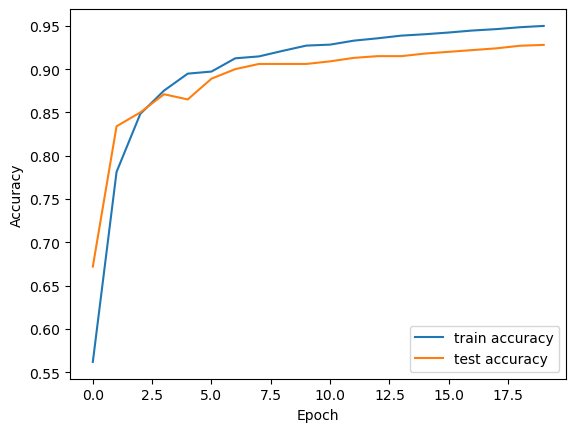


On train - best accuracy: 0.95, final accuracy: 0.95
On test - best accuracy: 0.93, final accuracy: 0.93


In [40]:
plt.plot(train_acc, label='train accuracy')
plt.plot(test_acc, label = 'test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show();

print("\nOn train - best accuracy: {:.2f}, final accuracy: {:.2f}".format(best_train_acc, train_acc[-1]))
print("On test - best accuracy: {:.2f}, final accuracy: {:.2f}".format(best_test_acc, test_acc[-1]))